# 08 Multi Likelihood Classification example 

_[Estimated time of execution: 3 min]_

This notebook shows how to train a multi-output dataset with different likelihoods using MOGPTK.

We create two artificial data sets: one of classification where `y ∈ {0,1}`, and one of a sinusoidal regression. We will use [`mogptk.gpr.MultiOutputLikelihood`](https://games-uchile.github.io/mogptk/gpr/likelihood.html#mogptk.gpr.likelihood.MultiOutputLikelihood) to use a different likelihood for each channel. Specifically, we'll use the [`mogptk.gpr.BernoulliLikelihood`](https://games-uchile.github.io/mogptk/gpr/likelihood.html#mogptk.gpr.likelihood.BernoulliLikelihood) for classification, and [`mogptk.gpr.StudentTLikelihood`](https://games-uchile.github.io/mogptk/gpr/likelihood.html#mogptk.gpr.likelihood.StudentTLikelihood) for regression.

In [1]:
import numpy as np
import mogptk
from sklearn.datasets import make_classification, make_regression

Create the artificial data set.

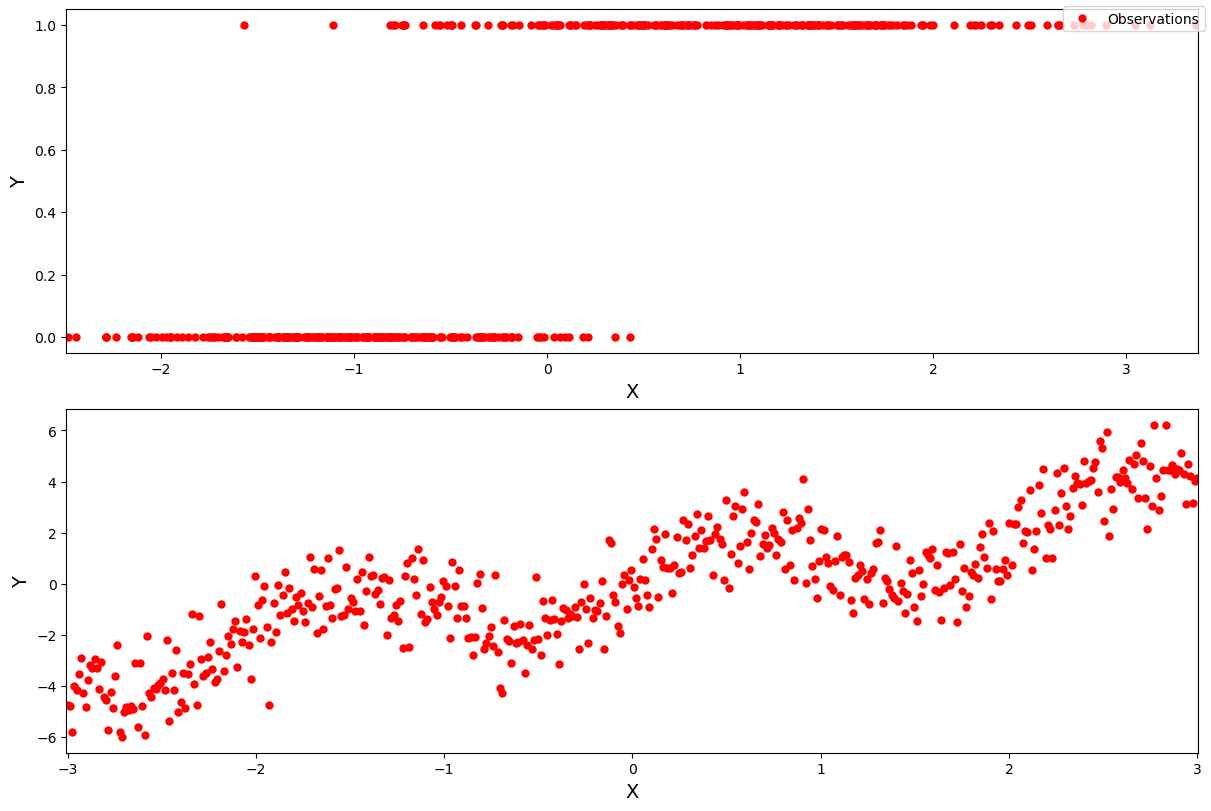

In [2]:
n = 500
X1, y1 = make_classification(n_samples=n, n_features=1,
                             n_informative=1, n_redundant=0,
                             n_clusters_per_class=1, random_state=1)
                             
X2 = np.linspace(-3.0, 3.0, n)
y2 = X2 + 1.5*np.sin(3.0*X2) + np.random.randn(n)

data = mogptk.DataSet(
    mogptk.Data(X1, y1),
    mogptk.Data(X2, y2),
)
data.plot();

Set up the model by using Hensman's Gaussian process inference, which allows us to use non-Gaussian likelihoods such as the [`mogptk.gpr.BernoulliLikelihood`](https://games-uchile.github.io/mogptk/gpr/likelihood.html#mogptk.gpr.likelihood.BernoulliLikelihood) and [`mogptk.gpr.StudentTLikelihood`](https://games-uchile.github.io/mogptk/gpr/likelihood.html#mogptk.gpr.likelihood.StudentTLikelihood) in this example. We will use the default squared exponential kernel for each channel and use the [`mogptk.gpr.multioutput.LinearModelOfCoregionalizationKernel`](https://games-uchile.github.io/mogptk/gpr/multioutput.html#mogptk.gpr.multioutput.LinearModelOfCoregionalizationKernel), also known as the LMC kernel, to learn the cross-channel features.

In [3]:
# Choose Bernoulli likelihood
likelihood = mogptk.gpr.MultiOutputLikelihood(
    mogptk.gpr.BernoulliLikelihood(),
    mogptk.gpr.StudentTLikelihood(),
)

# Choose inference
inference = mogptk.Hensman(likelihood=likelihood)

# Choose kernel
kernel = mogptk.gpr.LinearModelOfCoregionalizationKernel(
    mogptk.gpr.SquaredExponentialKernel(),
    mogptk.gpr.SquaredExponentialKernel(),
    output_dims=2,
)

# Set up model
model = mogptk.Model(data, kernel, inference=inference)

Training will be performed using the default Adam optimizer with a learning rate of `0.1` for a `250` iterations. We will additionally be measuring the error between the prediction and the target values using the mean absolute percentage error (MAPE), which is a relative error with respect to the target values.

Starting optimization using Adam
‣ Channels: 2
‣ Parameters: 501509
‣ Training points: 1000
‣ Iterations: 250
    0/250   0:00:00  loss=     2097.79  error=         100
   20/250   0:00:10  loss=     1046.76  error=     156.868
   41/250   0:00:21  loss=     954.991  error=       137.7
   62/250   0:00:31  loss=     922.191  error=     124.349
   83/250   0:00:41  loss=     910.982  error=     125.268
  102/250   0:00:52  loss=     906.859  error=     125.782
  122/250   0:01:02  loss=     903.873  error=     125.884
  143/250   0:01:12  loss=     901.265  error=     126.289
  164/250   0:01:22  loss=     899.143  error=     126.814
  184/250   0:01:33  loss=     897.737  error=     127.347
  203/250   0:01:43  loss=     896.036  error=     127.797
  223/250   0:01:53  loss=     894.803  error=     128.319
  243/250   0:02:03  loss=     893.882  error=      128.76
  250/250   0:02:07  loss=     893.849  error=     128.803
Optimization finished in 2 minutes 7 seconds


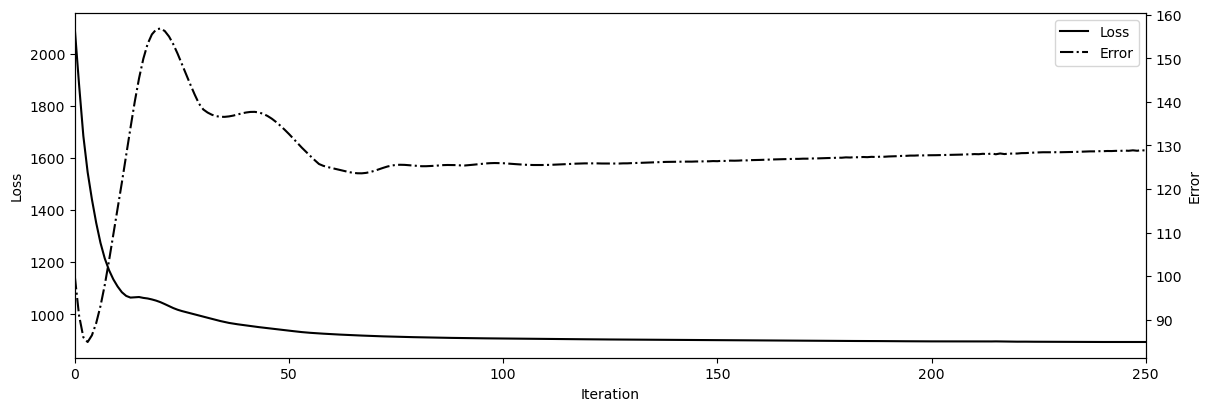

In [4]:
model.train(iters=250, verbose=True, error='mape', lr=0.1)
model.plot_losses();

After training we obtain the following results. Note that non-symmetric error bars are not possible yet, as such the Bernoulli likelihood extends beyond the [0,1] range.

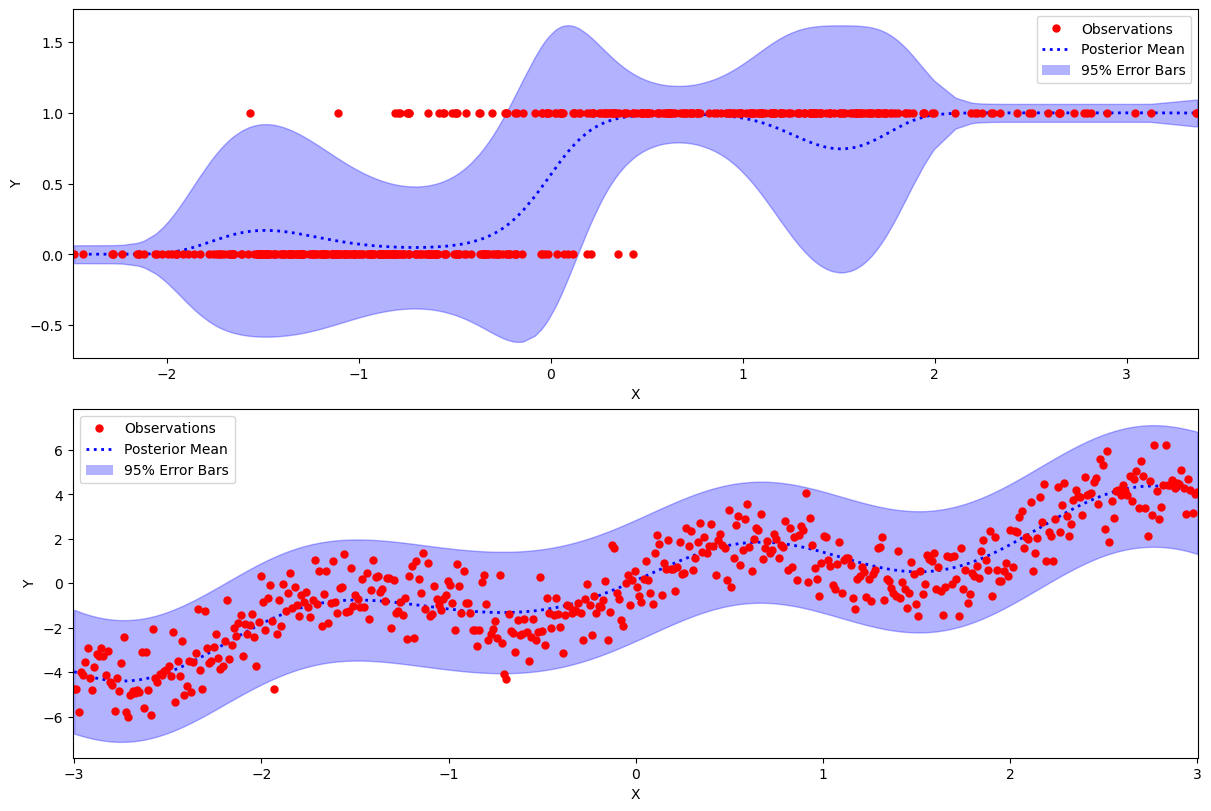

In [5]:
model.plot_prediction();